<a href="https://colab.research.google.com/github/elhamshaerirahbar-bot/my-colab-project/blob/main/Untitled17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [183]:
!pip install numpy pandas tensorflow

In [184]:
import numpy as np, pandas as pd, re, unicodedata
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, callbacks
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error

In [185]:
import pandas as pd, re, unicodedata
from difflib import get_close_matches

WANTED = ['factor A','factor B','factor C','factor D','Response 1 (Mn)', 'Response 2 (Mw)']

def norm(s: str) -> str:
    s = unicodedata.normalize("NFKC", str(s))
    s = s.replace("\ufeff","").replace("\u00a0"," ")
    s = re.sub(r"\s+"," ", s).strip()
    return s.lower()

df = pd.read_csv('Python.csv', sep=';', encoding='utf-8-sig')


name_map = {norm(c): c for c in df.columns}

def map_col(wanted: str):
    k = norm(wanted)
    if k in name_map:
        return name_map[k]

    cand = get_close_matches(k, list(name_map.keys()), n=1, cutoff=0.7)
    return name_map[cand[0]] if cand else None

mapped = [(w, map_col(w)) for w in WANTED]
missing = [w for w,c in mapped if c is None]
cols    = [c for _,c in mapped if c is not None]

print(f"Missing: {missing}")

n = 5
view = df[cols].head(n)
try:
    display(view)
except NameError:
    print(view.to_string(index=False))

Missing: []


,factor A,factor B,factor C,factor D,Response 1 (Mn),Response 2 (Mw)
0,110,7,50,10,1127.19,1321.65
1,85,4,50,30,1127.20,1321.66
2,101,1,500,60,1127.21,1321.67
3,79,1,219,10,1127.22,1321.68
4,50,1,500,20,1127.23,1321.69


In [186]:
# ---- pick columns via your map_col ----
FEATURES = [map_col('factor A'), map_col('factor B'),
            map_col('factor C'), map_col('factor D')]

TARGETS  = [map_col('Response 1 (Mn)'), map_col('Response 2 (Mw)')]  # دو خروجی

X = df[FEATURES].astype(float).to_numpy()   # shape: (n, 4)
y = df[TARGETS].astype(float).to_numpy()    # shape: (n, 2)

print("X:", X.shape, " y:", y.shape)

X: (25, 4)  y: (25, 2)


In [187]:
import numpy as np
from scipy.stats import rankdata
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler, MinMaxScaler

SEED = 55

def choose_bins(n_samples, min_per_bin=3, max_bins=5):
    # pick a safe upper bound before knowing split sizes
    return max(2, min(max_bins, n_samples // min_per_bin))

# ---- build combined rank key from both targets ----
y_score = rankdata(y[:,0]) + rankdata(y[:,1])

# ---- FIRST SPLIT: TrainVal / Test ----
# limit number of bins by the *actual* test count
test_frac = 0.10
n_test = int(np.ceil(len(y) * test_frac))

# initial desired bins
n_bins_1 = choose_bins(len(y))
# hard cap by test samples to satisfy sklearn's stratify constraint
n_bins_1 = max(2, min(n_bins_1, n_test))

kbin1 = KBinsDiscretizer(n_bins=n_bins_1, encode='ordinal', strategy='quantile')
y_bins_1 = kbin1.fit_transform(y_score.reshape(-1,1)).ravel().astype(int)

X_trainval, X_test, y_trainval, y_test, bins_tv_init, bins_te = train_test_split(
    X, y, y_bins_1, test_size=test_frac, shuffle=True, random_state=SEED, stratify=y_bins_1
)

# (optional) sanity check
# print("unique classes in first split:", np.unique(y_bins_1).size, " | n_test=", n_test)

# ---- SECOND SPLIT: Train / Val ----
val_frac_of_trainval = 0.1111
n_val = int(np.ceil(len(y_trainval) * val_frac_of_trainval))

y_score_tv = rankdata(y_trainval[:,0]) + rankdata(y_trainval[:,1])

n_bins_2 = choose_bins(len(y_trainval))
n_bins_2 = max(2, min(n_bins_2, n_val))

kbin2 = KBinsDiscretizer(n_bins=n_bins_2, encode='ordinal', strategy='quantile')
y_bins_2 = kbin2.fit_transform(y_score_tv.reshape(-1,1)).ravel().astype(int)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_frac_of_trainval,
    shuffle=True, random_state=SEED, stratify=y_bins_2
)

print("Shapes:")
print("  X:", X_train.shape, X_val.shape, X_test.shape)
print("  y:", y_train.shape, y_val.shape, y_test.shape)

Shapes:
  X: (19, 4) (3, 4) (3, 4)
  y: (19, 2) (3, 2) (3, 2)


In [188]:
x_scaler = StandardScaler().fit(X_train)
X_train_z = x_scaler.transform(X_train)
X_val_z   = x_scaler.transform(X_val)
X_test_z  = x_scaler.transform(X_test)

y_scaler = MinMaxScaler(feature_range=(-1, 1)).fit(y_train)
y_train_s = y_scaler.transform(y_train)
y_val_s   = y_scaler.transform(y_val)
y_test_s  = y_scaler.transform(y_test)

def inv_y(y_scaled):
    return y_scaler.inverse_transform(y_scaled)

def inv_y_cols(y_scaled):
    mn = y_scaler.inverse_transform(y_scaled)[:,0]
    mw = y_scaler.inverse_transform(y_scaled)[:,1]
    return mn, mw

print("y_train_s range per column (should be within [-1,1]):")
print(y_train_s.min(axis=0), y_train_s.max(axis=0))

y_train_s range per column (should be within [-1,1]):
[-1. -1.] [1. 1.]


In [189]:
ann = tf.keras.models.Sequential()

In [190]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras import layers, regularizers, callbacks
from tensorflow.keras.callbacks import EarlyStopping, Callback

SEED = 55
tf.random.set_seed(SEED)
np.random.seed(SEED)

class StopOnMSEGoal(Callback):
    def __init__(self, goal=1e-5):
        super().__init__()
        self.goal = goal
    def on_epoch_end(self, epoch, logs=None):
        if logs is not None and logs.get('loss', 1.0) <= self.goal:
            self.model.stop_training = True

# --- Model: Single hidden layer, Topology 4×20, tanh ---
model = Sequential([
    Dense(13, activation='tanh', input_shape=(4,)),  # Hidden layer: 20 neurons
    Dense(2, activation='tanh')                      # Output: 2 neurons (Mn, Mw) با tanh
])
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [191]:
model.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
goal_cb = StopOnMSEGoal(goal=1e-5)

history = model.fit(
    X_train_z, y_train_s,
    validation_data=(X_val_z, y_val_s),
    epochs=100, batch_size=4, verbose=1,
    callbacks=[es, goal_cb]
)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - loss: 0.7250 - mae: 0.7057 - mape: 211.2591 - val_loss: 0.8383 - val_mae: 0.8199 - val_mape: 593.0679
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.7061 - mae: 0.6952 - mape: 207.8987 - val_loss: 0.8284 - val_mae: 0.8140 - val_mape: 579.8373
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.6921 - mae: 0.6867 - mape: 204.7317 - val_loss: 0.8179 - val_mae: 0.8076 - val_mape: 566.0995
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.6787 - mae: 0.6783 - mape: 201.4553 - val_loss: 0.8070 - val_mae: 0.8010 - val_mape: 551.7523
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.6654 - mae: 0.6697 - mape: 198.0551 - val_loss: 0.7959 - val_mae: 0.7940 - val_mape: 536.7537
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.6522 - mae: 0.6615 - mape: 194.6291 - val_loss: 0.7846 - val_mae: 0.7869 - val_mape: 521.0891
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.6391 - mae: 0.6

In [192]:
def inv_y(y_s):
    return y_scaler.inverse_transform(y_s)

y_pred_test_s = model.predict(X_test_z)
y_pred_test   = inv_y(y_pred_test_s)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


In [193]:
from sklearn.metrics import mean_squared_error
mse_Mn = mean_squared_error(y_test[:,0], y_pred_test[:,0])
mse_Mw = mean_squared_error(y_test[:,1], y_pred_test[:,1])
print(f"MSE(Mn) real = {mse_Mn:.4f} | MSE(Mw) real = {mse_Mw:.4f}")

# خلاصه پارامترها
model.summary()

MSE(Mn) real = 0.0049 | MSE(Mw) real = 0.0044


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 13)             │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 2)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 281 (1.10 KB)

 Trainable params: 93 (372.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 188 (756.00 B)

In [194]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred_test_s = model.predict(X_test_z)
y_pred_test   = y_scaler.inverse_transform(y_pred_test_s)

mse_Mn = mean_squared_error(y_test[:,0], y_pred_test[:,0])
mse_Mw = mean_squared_error(y_test[:,1], y_pred_test[:,1])
r2_Mn  = r2_score(y_test[:,0], y_pred_test[:,0])
r2_Mw  = r2_score(y_test[:,1], y_pred_test[:,1])
r2_avg = r2_score(y_test, y_pred_test, multioutput='uniform_average')

print(f"MSE(Mn) real = {mse_Mn:.6f} | MSE(Mw) real = {mse_Mw:.6f}")
print(f"R² (Mn)      = {r2_Mn:.4f}  | R² (Mw)      = {r2_Mw:.4f}  | R²_avg = {r2_avg:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
MSE(Mn) real = 0.004911 | MSE(Mw) real = 0.004374
R² (Mn)      = 0.1230  | R² (Mw)      = 0.2188  | R²_avg = 0.1709


In [195]:
# --- ارزیابی در واحد واقعی ---
#y_pred_test = model.predict(X_test_s, verbose=0)

def rmse(a,b): return np.sqrt(mean_squared_error(a,b))
def sep(a,b):
    n = len(a)
    return np.sqrt(np.sum((a-b)**2)/(n-1))

for j,name in enumerate(['Mn','Mw']):
    print(f'{name}: RMSE={rmse(y_test[:,j], y_pred_test[:,j]):.3f} | '
          f'R²={r2_score(y_test[:,j], y_pred_test[:,j]):.4f} | '
          f'SEP={sep(y_test[:,j], y_pred_test[:,j]):.3f}')

Mn: RMSE=0.070 | R²=0.1230 | SEP=0.086
Mw: RMSE=0.066 | R²=0.2188 | SEP=0.081


In [196]:
#Vorhersagen (zuerst im skalierten Raum, dann zurück in echte Einheiten)
y_hat_train_s = model.predict(X_train_z, verbose=1)
y_hat_val_s   = model.predict(X_val_z,   verbose=1)
y_hat_test_s  = model.predict(X_test_z,  verbose=1)

y_hat_train = inv_y(y_hat_train_s)
y_hat_val   = inv_y(y_hat_val_s)
y_hat_test  = inv_y(y_hat_test_s)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


In [197]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

def report_2out(name, yt, yp, labels=("Mn", "Mw")):
    # yt و yp باید (n,2) باشن
    for i, label in enumerate(labels):
        y_true = yt[:, i].reshape(-1)
        y_pred = yp[:, i].reshape(-1)

        mae  = mean_absolute_error(y_true, y_pred)
        mse  = mean_squared_error(y_true, y_pred)
        r2   = r2_score(y_true, y_pred)
        mape = mean_absolute_percentage_error(y_true, y_pred)

        print(f"[{name}] {label}: MAE={mae:.6f}  MSE={mse:.6f}  R²={r2:.4f}  MAPE={mape:.6f}")

In [198]:
report_2out("Train", y_train, y_hat_train)
report_2out("Val  ", y_val,   y_hat_val)
report_2out("Test ", y_test,  y_hat_test)

[Train] Mn: MAE=0.055326  MSE=0.004300  R²=0.0755  MAPE=0.000049
[Train] Mw: MAE=0.053568  MSE=0.003996  R²=0.1408  MAPE=0.000041
[Val  ] Mn: MAE=0.071077  MSE=0.007912  R²=0.0299  MAPE=0.000063
[Val  ] Mw: MAE=0.071349  MSE=0.007728  R²=0.0525  MAPE=0.000054
[Test ] Mn: MAE=0.066201  MSE=0.004911  R²=0.1230  MAPE=0.000059
[Test ] Mw: MAE=0.058783  MSE=0.004374  R²=0.2188  MAPE=0.000044


In [199]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 1) پیش‌بینی در فضای ورودی‌های استانداردشده
y_pred_train_s = model.predict(X_train_z)
y_pred_val_s   = model.predict(X_val_z)
y_pred_test_s  = model.predict(X_test_z)

# 2) برگرداندن پیش‌بینی‌ها به واحد واقعی (IMPORTANT)
y_pred_train = y_scaler.inverse_transform(y_pred_train_s)
y_pred_val   = y_scaler.inverse_transform(y_pred_val_s)
y_pred_test  = y_scaler.inverse_transform(y_pred_test_s)

# (اختیاری) اطمینان از اینکه y_true هم واقعاً در واحد واقعی است:
print('y_train real min/max per col:', y_train.min(axis=0), y_train.max(axis=0))

# 3) R² جداگانه برای Mn و Mw
print("Train R2:", r2_score(y_train, y_pred_train, multioutput='raw_values'))
print("Val   R2:", r2_score(y_val,   y_pred_val,   multioutput='raw_values'))
print("Test  R2:", r2_score(y_test,  y_pred_test,  multioutput='raw_values'))

# 4) سایر معیارها در واحد واقعی
def eval_block(name, y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred, multioutput='raw_values')
    rmse = (mse**0.5)
    mae  = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
    # MAPE دستی (از تقسیم بر صفر جلوگیری شود)
    import numpy as np
    eps = 1e-12
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps)), axis=0) * 100
    print(f"{name} -> MSE={mse}, RMSE={rmse}, MAE={mae}, MAPE%={mape}")

for split, y_true, y_pred in [
    ("Train", y_train, y_pred_train),
    ("Val",   y_val,   y_pred_val),
    ("Test",  y_test,  y_pred_test)
]:
    eval_block(split, y_true, y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
y_train real min/max per col: [1127.2  1321.66] [1127.43 1321.89]
Train R2: [0.07552336 0.14084123]
Val   R2: [0.02990292 0.0524661 ]
Test  R2: [0.12304181 0.21884121]
Train -> MSE=[0.00430022 0.0039964 ], RMSE=[0.0655761  0.06321706], MAE=[0.05532612 0.05356779], MAPE%=[0.00490783 0.00405275]
Val -> MSE=[0.00791168 0.00772767], RMSE=[0.08894763 0.08790714], MAE=[0.07107747 0.07134928], MAPE%=[0.00630498 0.00539792]
Test -> MSE=[0.00491097 0.00437449], RMSE=[0.07007828 0.06613992], MAE=[0.06620117 0.05878255], MAPE%=[0.00587236 0.00444716]


In [200]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def summarize_split(name, y_true, y_pred):
    var = np.var(y_true, axis=0, ddof=1)
    mse = mean_squared_error(y_true, y_pred, multioutput='raw_values')
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
    r2  = r2_score(y_true, y_pred, multioutput='raw_values')

    # baseline = پیش‌بینیِ میانگینِ y_true
    y_mean = np.tile(np.mean(y_true, axis=0, keepdims=True), (y_true.shape[0],1))
    mse_base = mean_squared_error(y_true, y_mean, multioutput='raw_values')
    r2_base  = r2_score(y_true, y_mean, multioutput='raw_values')

    print(f"{name}: Var={var} | R2={r2} | RMSE={rmse} | MAE={mae} | (Baseline R2={r2_base}, Baseline RMSE={np.sqrt(mse_base)})")

summarize_split("Train", y_train, y_pred_train)
summarize_split("Val",   y_val,   y_pred_val)
summarize_split("Test",  y_test,  y_pred_test)

Train: Var=[0.00490994 0.00490994] | R2=[0.07552336 0.14084123] | RMSE=[0.0655761  0.06321706] | MAE=[0.05532612 0.05356779] | (Baseline R2=[0. 0.], Baseline RMSE=[0.06820208 0.06820208])
Val: Var=[0.01223333 0.01223333] | R2=[0.02990292 0.0524661 ] | RMSE=[0.08894763 0.08790714] | MAE=[0.07107747 0.07134928] | (Baseline R2=[0. 0.], Baseline RMSE=[0.09030811 0.09030811])
Test: Var=[0.0084 0.0084] | R2=[0.12304181 0.21884121] | RMSE=[0.07007828 0.06613992] | MAE=[0.06620117 0.05878255] | (Baseline R2=[0. 0.], Baseline RMSE=[0.07483315 0.07483315])


In [201]:
!pip install matplotlib

In [202]:
import matplotlib.pyplot as plt
%matplotlib inline

In [203]:
import numpy as np, pandas as pd

def make_table_multi(split, y_true, y_pred, target_names=("Mn","Mw"), n=None):
    """
    Baut eine Tabelle für 2 (oder mehr) Outputs.
    y_true, y_pred: Form (n, k)  -> k = Anzahl Outputs (hier 2: Mn, Mw)
    pct_error in Prozent (0–100). Für Anteil (0–1) unten scale=1 nutzen.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    assert y_true.shape == y_pred.shape and y_true.ndim == 2, "y muss (n,k) sein"
    k = y_true.shape[1]
    assert k == len(target_names), "target_names-Länge passt nicht zu y.shape[1]"

    parts = []
    for j, name in enumerate(target_names):
        df = pd.DataFrame({
            "split":     split,
            "target":    name,
            "actual":    y_true[:, j],
            "predicted": y_pred[:, j],
        })
        df["residual"]  = df["actual"] - df["predicted"]
        df["abs_error"] = df["residual"].abs()
        # Prozent-Fehler (×100). Wenn du Bruchteil willst, ersetze 100 durch 1.
        df["pct_error"] = 100 * df["abs_error"] / df["actual"].abs().clip(lower=1e-8)
        parts.append(df if n is None else df.head(n))
    return pd.concat(parts, ignore_index=True)

# Beispiel-Nutzung (y_* und y_hat_* haben Form (n,2) = [Mn, Mw]):
tbl_train = make_table_multi("Train", y_train, y_hat_train, target_names=("Mn","Mw"))
tbl_val   = make_table_multi("Val",   y_val,   y_hat_val,   target_names=("Mn","Mw"))
tbl_test  = make_table_multi("Test",  y_test,  y_hat_test,  target_names=("Mn","Mw"))

tbl_all = pd.concat([tbl_train, tbl_val, tbl_test], ignore_index=True)
print(tbl_all.to_string(index=False))   # in Notebook: display(tbl_all)

split target  actual   predicted  residual  abs_error  pct_error
Train     Mn 1127.23 1127.326782 -0.096782   0.096782   0.008586
Train     Mn 1127.29 1127.312134 -0.022134   0.022134   0.001963
Train     Mn 1127.20 1127.298340 -0.098340   0.098340   0.008724
Train     Mn 1127.25 1127.259521 -0.009521   0.009521   0.000845
Train     Mn 1127.40 1127.300903  0.099097   0.099097   0.008790
Train     Mn 1127.33 1127.308350  0.021650   0.021650   0.001921
Train     Mn 1127.27 1127.312256 -0.042256   0.042256   0.003749
Train     Mn 1127.36 1127.295410  0.064590   0.064590   0.005729
Train     Mn 1127.43 1127.344971  0.085029   0.085029   0.007542
Train     Mn 1127.22 1127.294067 -0.074067   0.074067   0.006571
Train     Mn 1127.26 1127.348755 -0.088755   0.088755   0.007874
Train     Mn 1127.37 1127.328857  0.041143   0.041143   0.003649
Train     Mn 1127.38 1127.367432  0.012568   0.012568   0.001115
Train     Mn 1127.21 1127.318115 -0.108115   0.108115   0.009591
Train     Mn 1127.28 1127

In [204]:
# ---- 0) Reproducibility / Determinism ----
import os, random, numpy as np, tensorflow as tf

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
try:
    tf.keras.utils.set_random_seed(SEED)
    tf.config.experimental.enable_op_determinism(True)
except Exception:
    pass

In [205]:
# ---- 5) Activation (Transfer Function) sweep on hidden layers ----
import random, numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, optimizers

activations = ['relu', 'tanh', 'sigmoid', 'softplus']
labels      = ['ReLU', 'Tanh', 'Sigmoid', 'Softplus']

val_mse_real  = []
test_mse_real = []

In [206]:
for act in activations:

    tf.keras.backend.clear_session()
    np.random.seed(SEED); random.seed(SEED); tf.random.set_seed(SEED)

    model = tf.keras.Sequential([
        layers.Input(shape=(X_train_z.shape[1],)),
        layers.Dense(16, activation=act),
        layers.Dense(2,  activation='tanh')     # ⬅️ zwei Ausgänge: [Mn, Mw]
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                  loss='mse', metrics=['mae'])

    history = model.fit(
        X_train_z, y_train_s,                    # y_train_s: (n,2)
        validation_data=(X_val_z, y_val_s),
        epochs=200, batch_size=16, shuffle=True, verbose=1,
        callbacks=[]
    )

Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - loss: 0.6171 - mae: 0.6149 - val_loss: 1.1644 - val_mae: 0.8984
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.6065 - mae: 0.6087 - val_loss: 1.1516 - val_mae: 0.8935
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.5968 - mae: 0.6031 - val_loss: 1.1392 - val_mae: 0.8887
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.5873 - mae: 0.5979 - val_loss: 1.1271 - val_mae: 0.8839
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.5781 - mae: 0.5929 - val_loss: 1.1152 - val_mae: 0.8791
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.5692 - mae: 0.5880 - val_loss: 1.1035 - val_mae: 0.8743
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.5604 - mae: 0.5835 - val_loss: 1.0920 - val_mae: 0.8695
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.5519 - mae: 0.5792 - val_loss: 1.0807 - val_mae: 0.8648
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.5436 - m

In [207]:

    # Vorhersage (skaliert) -> zurückskalieren
    y_hat_train_s = model.predict(X_train_z, verbose=0)
    y_hat_val_s   = model.predict(X_val_z,   verbose=0)
    y_hat_test_s  = model.predict(X_test_z,  verbose=0)

    y_hat_train = inv_y(y_hat_train_s)          # (n,2) in realen Einheiten
    y_hat_val   = inv_y(y_hat_val_s)
    y_hat_test  = inv_y(y_hat_test_s)

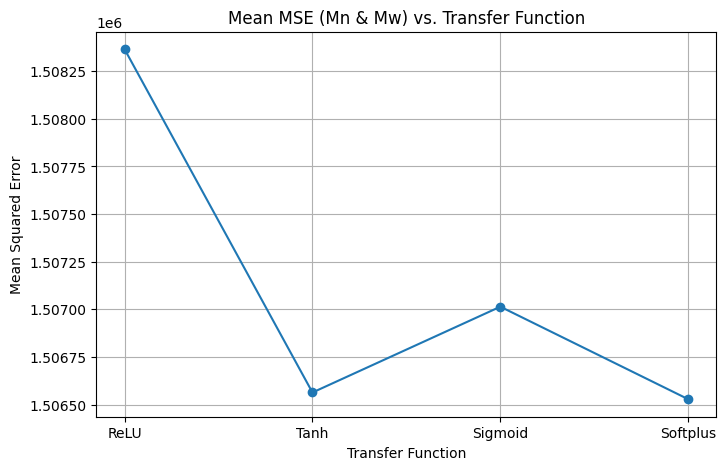

In [208]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

transfer_functions = {
    'relu': 'ReLU',
    'tanh': 'Tanh',
    'sigmoid': 'Sigmoid',
    'softplus': 'Softplus'
}

mse_results = []

for activation, name in transfer_functions.items():
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(16, activation=activation))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='tanh'))   # ⬅️ zwei Outputs: [Mn, Mw]
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, batch_size=4, epochs=50, verbose=0)
    y_pred = model.predict(X_test, verbose=0)  # Form (n,2)
    # Durchschnitts-MSE über beide Outputs (Mn & Mw)
    mse = mean_squared_error(y_test, y_pred)   # = uniform_average
    mse_results.append(mse)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(list(transfer_functions.values()), mse_results, marker='o', linestyle='-')
plt.title('Mean MSE (Mn & Mw) vs. Transfer Function')
plt.xlabel('Transfer Function')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.show()

In [209]:
# y فعلی طول 50 دارد و X.shape[0] == 25
y = y.reshape(X.shape[0], 2)   # حالا y.shape == (25, 2)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_predict

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LinearRegression())
])

cv = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred = cross_val_predict(pipe, X, y, cv=cv)

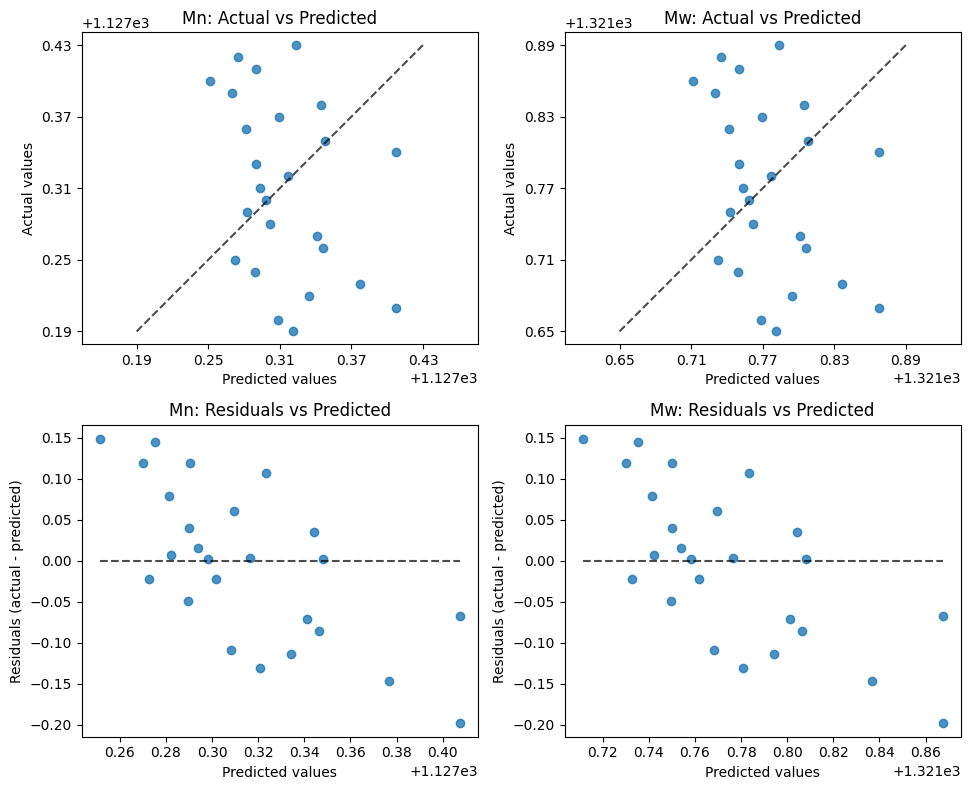

In [210]:
import matplotlib.pyplot as plt
from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
names = ["Mn", "Mw"]

for j in range(2):
    PredictionErrorDisplay.from_predictions(
        y_true=y[:, j], y_pred=y_pred[:, j],
        kind="actual_vs_predicted", subsample=None, ax=axs[0, j], random_state=42
    )
    axs[0, j].set_title(f"{names[j]}: Actual vs Predicted")

    PredictionErrorDisplay.from_predictions(
        y_true=y[:, j], y_pred=y_pred[:, j],
        kind="residual_vs_predicted", subsample=None, ax=axs[1, j], random_state=42
    )
    axs[1, j].set_title(f"{names[j]}: Residuals vs Predicted")

plt.tight_layout(); plt.show()

In [211]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import (
    r2_score, mean_absolute_percentage_error, mean_squared_error,
    mean_squared_log_error, explained_variance_score, max_error,
    median_absolute_error
)

In [212]:
df = pd.read_csv("Python.csv", engine="python", sep=r";")
df.columns = (df.columns
              .str.replace('\ufeff', '', regex=False)   # حذف BOM
              .str.strip()
              .str.replace(r'\s+', ' ', regex=True))    # یکی‌کردن فاصله‌ها

print("ستون‌های موجود:", list(df.columns))  # کمک برای چک کردن

# 2) نگاشتِ نام‌ها به‌صورت Case-Insensitive (بی‌حساسیت به بزرگی/کوچکی حروف)
def pick_cols(df, names):
    lookup = {c.casefold(): c for c in df.columns}
    missing = [n for n in names if n.casefold() not in lookup]
    if missing:
        raise KeyError(f"ستون‌های پیدا نشدند: {missing}\nموجود: {list(df.columns)}")
    return [lookup[n.casefold()] for n in names]

FEATURES_REQ = ['factor A', 'factor B', 'factor C', 'factor D']
TARGETS_REQ  = ['Response 1 (Mn)', 'Response 2 (Mw)']

FEATURES = pick_cols(df, FEATURES_REQ)
TARGETS  = pick_cols(df, TARGETS_REQ)

ستون‌های موجود: ['factor A', 'factor B', 'factor C', 'factor D', 'Response 1 (Mn)', 'Response 2 (Mw)']


In [213]:
X = df[FEATURES].to_numpy(dtype=float)
Y = df[TARGETS].to_numpy(dtype=float)

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, shuffle=True
)

X_trval, X_test, Y_trval, Y_test = train_test_split(
    X, Y, test_size=5, random_state=42, shuffle=True
)

n_samples = X.shape[0]

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_trval.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Total: {n_samples} samples\n")

Training set: 20 samples
Validation set: 20 samples
Test set: 5 samples
Total: 25 samples



In [214]:
for col in FEATURES + TARGETS:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.').str.strip(),
                            errors='coerce')

# 4) ساخت X و Y
X = df[FEATURES].to_numpy(dtype=float)
Y = df[TARGETS].to_numpy(dtype=float)

print("X shape:", X.shape, "Y shape:", Y.shape)
n_samples = X.shape[0]

X shape: (25, 4) Y shape: (25, 2)


In [215]:
base_svr = make_pipeline(StandardScaler(),SVR(kernel='poly', C=1 , epsilon= 0.1, gamma='scale')
)
model = MultiOutputRegressor(base_svr)
model.fit(X_train, Y_train)

MultiOutputRegressor(estimator=Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('svr',
                                                SVR(C=1, kernel='poly'))]))

In [216]:
model.fit(X_train, Y_train)
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
Y_pred = model.predict(X_test)
print("Test predictions shape:", Y_pred.shape)
def overall_metrics(y_true, y_pred):
    r2   = r2_score(y_true, y_pred, multioutput='uniform_average')
    evs  = explained_variance_score(y_true, y_pred, multioutput='uniform_average')
    mape = mean_absolute_percentage_error(y_true, y_pred, multioutput='uniform_average')
    mse  = mean_squared_error(y_true, y_pred, multioutput='uniform_average')
    try:
        msle = mean_squared_log_error(y_true, y_pred, multioutput='uniform_average')
    except ValueError:
        msle = np.nan
    # Median AE را دستی روی هر خروجی بگیریم و میانگین کنیم
    mae_med = np.mean([median_absolute_error(y_true[:,i], y_pred[:,i]) for i in range(y_true.shape[1])])
    # Max Error را روی کل عناصر محاسبه کنیم
    maxerr = np.max(np.abs(y_true - y_pred))
    return evs, maxerr, mape, mse, msle, mae_med, r2
evs, maxerr, mape, mse, msle, mae_med, r2 = overall_metrics(Y_test, Y_pred)
print("SVM Results:")
print(f"Explained Variance: {evs:.6f}")
print(f"Max Error: {maxerr:.6f}")
print(f"MAPE: {mape:.6f}")
print(f"MSE: {mse:.6f}")
print(f"MSLE: {msle:.6f}")
print(f"Median AE: {mae_med:.6f}")
print(f"R²: {r2:.6f}\n")

Test predictions shape: (5, 2)
SVM Results:
Explained Variance: 0.371681
Max Error: 0.093440
MAPE: 0.000045
MSE: 0.003752
MSLE: 0.000000
Median AE: 0.050647
R²: 0.368801



In [217]:
test_df = pd.DataFrame({
    "Actual_Mn":     Y_test[:,0],
    "Actual_Mw":     Y_test[:,1],
    "Predicted_Mn":  Y_pred[:,0],
    "Predicted_Mw":  Y_pred[:,1],
})
print("Actual vs Predicted Comparison (Test):")
print(test_df.to_string(index=False))
print()

Actual vs Predicted Comparison (Test):
 Actual_Mn  Actual_Mw  Predicted_Mn  Predicted_Mw
   1127.27    1321.73   1127.320647   1321.780647
   1127.35    1321.81   1127.317766   1321.777766
   1127.19    1321.65   1127.268218   1321.728218
   1127.42    1321.88   1127.326560   1321.786560
   1127.30    1321.76   1127.317493   1321.777493



In [218]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
r2_list, mse_list, mape_list = [], [], []

for tr_idx, va_idx in kf.split(X):
    X_tr, X_va = X[tr_idx], X[va_idx]
    Y_tr, Y_va = Y[tr_idx], Y[va_idx]
    m = MultiOutputRegressor(make_pipeline(StandardScaler(), SVR(kernel='poly', C=1, epsilon=0.1, gamma='scale')))
    m.fit(X_tr, Y_tr)
    Y_va_pred = m.predict(X_va)
    r2_list.append(r2_score(Y_va, Y_va_pred, multioutput='uniform_average'))
    mse_list.append(mean_squared_error(Y_va, Y_va_pred, multioutput='uniform_average'))
    mape_list.append(mean_absolute_percentage_error(Y_va, Y_va_pred, multioutput='uniform_average'))

r2_arr   = np.array(r2_list)
mse_arr  = np.array(mse_list)
mape_arr = np.array(mape_list)

print("\n5-FOLD CROSS VALIDATION RESULTS")
print("============================================================")
print(f"R² Mean: {r2_arr.mean():.4f} (±{r2_arr.std():.4f})")
print(f"MSE Mean: {mse_arr.mean():.4f} (±{mse_arr.std():.4f})")
print(f"MAPE Mean: {mape_arr.mean():.4f} (±{mape_arr.std():.4f})\n")

print("Individual R² scores:", np.array2string(r2_arr, precision=4))
print("Individual MSE scores:", np.array2string(mse_arr, precision=4))
print("Individual MAPE scores:", np.array2string(mape_arr, precision=4))




5-FOLD CROSS VALIDATION RESULTS
R² Mean: -2.4861 (±4.4807)
MSE Mean: 0.0052 (±0.0020)
MAPE Mean: 0.0001 (±0.0000)

Individual R² scores: [  0.3688  -0.2553  -1.2842 -11.3763   0.1165]
Individual MSE scores: [0.0038 0.0065 0.0063 0.0074 0.002 ]
Individual MAPE scores: [4.4712e-05 5.6870e-05 5.1566e-05 6.7652e-05 3.0318e-05]


In [219]:
model_all = MultiOutputRegressor(make_pipeline(StandardScaler(), SVR(kernel='rbf', C=10.0, epsilon=0.01, gamma='scale')))
model_all.fit(X, Y)
Y_all_pred = model_all.predict(X)

all_df = pd.DataFrame({
    "Sample": np.arange(1, n_samples+1),
    "Actual_Mn": Y[:,0],
    "Actual_Mw": Y[:,1],
    "Predicted_Mn": Y_all_pred[:,0],
    "Predicted_Mw": Y_all_pred[:,1],
})
all_df["Error_Mn"] = (all_df["Actual_Mn"] - all_df["Predicted_Mn"]).abs()
all_df["Error_Mw"] = (all_df["Actual_Mw"] - all_df["Predicted_Mw"]).abs()

print("\nActual vs Predicted Comparison (All samples):")
for i, row in all_df.iterrows():
    a_mn, a_mw = row["Actual_Mn"], row["Actual_Mw"]
    p_mn, p_mw = row["Predicted_Mn"], row["Predicted_Mw"]
    print(f"Sample {int(row['Sample']):2d}: Actual=[ {a_mn:7.2f}, {a_mw:7.2f} ] | Predicted=[ {p_mn:7.2f}, {p_mw:7.2f} ]")

print("\nDetailed Comparison Table:")
print(all_df.to_string(index=False))
# ==== end ====


Actual vs Predicted Comparison (All samples):
Sample  1: Actual=[ 1127.19, 1321.65 ] | Predicted=[ 1127.20, 1321.66 ]
Sample  2: Actual=[ 1127.20, 1321.66 ] | Predicted=[ 1127.21, 1321.67 ]
Sample  3: Actual=[ 1127.21, 1321.67 ] | Predicted=[ 1127.33, 1321.79 ]
Sample  4: Actual=[ 1127.22, 1321.68 ] | Predicted=[ 1127.23, 1321.69 ]
Sample  5: Actual=[ 1127.23, 1321.69 ] | Predicted=[ 1127.30, 1321.76 ]
Sample  6: Actual=[ 1127.24, 1321.70 ] | Predicted=[ 1127.31, 1321.77 ]
Sample  7: Actual=[ 1127.25, 1321.71 ] | Predicted=[ 1127.26, 1321.72 ]
Sample  8: Actual=[ 1127.26, 1321.72 ] | Predicted=[ 1127.27, 1321.73 ]
Sample  9: Actual=[ 1127.27, 1321.73 ] | Predicted=[ 1127.28, 1321.74 ]
Sample 10: Actual=[ 1127.28, 1321.74 ] | Predicted=[ 1127.29, 1321.75 ]
Sample 11: Actual=[ 1127.29, 1321.75 ] | Predicted=[ 1127.28, 1321.74 ]
Sample 12: Actual=[ 1127.30, 1321.76 ] | Predicted=[ 1127.31, 1321.77 ]
Sample 13: Actual=[ 1127.31, 1321.77 ] | Predicted=[ 1127.32, 1321.78 ]
Sample 14: Actual